In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from transformers import BertTokenizer

In [2]:
df=pd.read_excel('dataset_filledsupplier_currency_orderday.xlsx')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24621 entries, 0 to 24620
Data columns (total 32 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   청구서번호        24621 non-null  object 
 1   No.          24621 non-null  int64  
 2   Subject      24599 non-null  object 
 3   Machinery    24621 non-null  object 
 4   Assembly     24621 non-null  object 
 5   청구품목         24621 non-null  object 
 6   Unnamed: 6   0 non-null      float64
 7   Part No.1    24602 non-null  object 
 8   Part No.2    3592 non-null   object 
 9   청구량          24517 non-null  float64
 10  견적           24171 non-null  object 
 11  견적수량         24517 non-null  float64
 12  견적화폐         24621 non-null  object 
 13  견적단가         24621 non-null  float64
 14  발주번호         24621 non-null  object 
 15  발주처          24621 non-null  object 
 16  발주           24621 non-null  object 
 17  발주수량         24621 non-null  int64  
 18  발주금액         24621 non-null  float64
 19  D/T 

In [4]:
print(len(df['발주처'].unique()))

81


## 클리닝

In [5]:
missing_conditions = df[
    df['발주'].notnull() &  # 발주 일자는 비어있지 않음
    df['미입고 기간'].isnull() &  # 미입고 기간은 비어있음
    df['창고입고'].isnull() & # 창고 입고도 비어있음
    df['선박입고'].isnull()  # 선박 입고도 비어있음

]

print(f"발주 일자는 있지만 미입고 기간, 창고 입고, 선박 입고도 없는 경우: {len(missing_conditions)}개")
df = df.drop(missing_conditions.index)

print(f"삭제된 행의 개수: {len(missing_conditions)}개")
print(f"남은 데이터프레임의 크기: {df.shape}")

발주 일자는 있지만 미입고 기간, 창고 입고, 선박 입고도 없는 경우: 1699개
삭제된 행의 개수: 1699개
남은 데이터프레임의 크기: (22922, 32)


In [6]:
#미입고기간으로 처리.
missing_both = df[df['창고입고'].isnull() & df['미입고 기간'].notnull()]

print(f"창고 입고일은 없고 미입고 기간은 명시되어 있어 미입고 기간으로 분류해야 할 경우 : {len(missing_both)}개")

창고 입고일은 없고 미입고 기간은 명시되어 있어 미입고 기간으로 분류해야 할 경우 : 1620개


In [7]:

df['발주'] = pd.to_datetime(df['발주'], errors='coerce')
df['창고입고'] = pd.to_datetime(df['창고입고'], errors='coerce')

# 리드타임 계산
df['리드타임'] = (df['창고입고'] - df['발주']).dt.days

# 리드타임이 0인 경우 1로 변경
df['리드타임'] = df['리드타임'].apply(lambda x: 1 if x == 0 else x)

In [8]:
df = df[df['미입고 기간'].isnull()]

df['발주'] = pd.to_datetime(df['발주'], errors='coerce')
df['창고입고'] = pd.to_datetime(df['창고입고'], errors='coerce')

# 리드타임 계산
df['리드타임'] = (df['창고입고'] - df['발주']).dt.days

# 리드타임이 0인 경우 1로 변경
df['리드타임'] = df['리드타임'].apply(lambda x: 1 if x == 0 else x)

# 리드타임이 1일 미만이거나 200일을 초과한 경우 제거
df = df[(df['리드타임'] > 0 ) & (df['리드타임'] < 200)]

# 창고입고가 결측값인 행 제거
df = df.dropna(subset=['창고입고'])

print(df.shape)

(19765, 33)


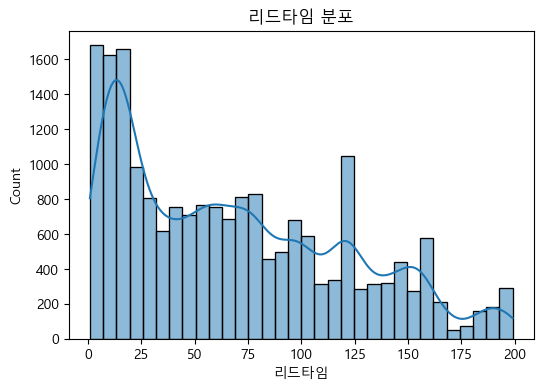

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# 리드타임 분포 확인
plt.rcParams['font.family']='Malgun Gothic'

plt.figure(figsize=(6, 4))
sns.histplot(df['리드타임'], kde=True)
plt.title('리드타임 분포')
plt.show()

In [10]:
df.head()

,청구서번호,No.,Subject,Machinery,Assembly,청구품목,Unnamed: 6,Part No.1,Part No.2,청구량,...,Control No.,입고창고,창고출고,창고출고수량,출고선박,출고운반선,선박입고,선박입고수량,완료 여부,리드타임
0,COK-BS-DSP-1901004,1,COK-F-DECK-190104-01,CARGO BOOM VANG BLOCK (STBD 하),BLOCK,"MCKISSICK CONSTRUCTION BLOCKS (WIRE SIZE : 5/8"")",NaN,C15S10BS,2103170,2.0,...,19-04-077,BW,2019-05-20,2,COK,ONENESS,2019-06-09,2,완료,112
1,COK-BS-DSP-1901004,2,COK-F-DECK-190104-01,SPANISH BOOM VANG BLOCK (PORT 상),BLOCK,"MCKISSICK CONSTRUCTION BLOCKS (WIRE SIZE : 5/8"")",NaN,C15D10BS,2103180,1.0,...,19-04-064,BW,2019-05-20,1,COK,ONENESS편 탁송,2019-06-09,1,완료,97
2,COK-BS-DSP-1901004,3,COK-F-DECK-190104-01,PURSE BLOCK,TOW BLOCK,WESTEC 20TON TOW BLOCK,NaN,WESTEC 20TON TOW BLOCK,NaN,1.0,...,19-04-077,BW,2019-05-20,1,COK,ONENESS,2019-06-09,1,완료,112
3,COK-BS-DSP-1905036,1,폰페이 재고정정,MAIN ENGINE,POWER PACK AS,GE POWER PACK FORK - E7(B),NaN,40028340,NaN,8.0,...,NaN,PN,2019-08-01,1,DEO,HANARO,2019-08-24,1,완료,1
4,COK-BS-DSP-1905036,2,폰페이 재고정정,MAIN ENGINE,POWER PACK AS,GE POWER PACK FORK - E7(B),NaN,40028340,NaN,8.0,...,NaN,PN,2019-08-29,7,ELS,SL ARCHI,2019-09-30,7,완료,1


In [11]:
print(df['리드타임'].describe())


count    19765.000000
mean        67.950873
std         52.245829
min          1.000000
25%         19.000000
50%         59.000000
75%        105.000000
max        199.000000
Name: 리드타임, dtype: float64


### 리드타임 예측 (회귀)
1. 텍스트 칼럼 결합 및 BERT 임베딩
2. ( 수치형 데이터(견적단가 및 발주량) Scaling )
3. 범주형 데이터(견적화폐) onehotEncoding
4. 모델의 입력, 2.3데이터 결합 => 리드타임 예측

## 전처리

> 각 텍스트 필드 개별적으로 rf idf 변환하고 결합

In [70]:
#!conda install conda-forge::category_encoders -y

In [13]:
df.head()

,청구서번호,No.,Subject,Machinery,Assembly,청구품목,Unnamed: 6,Part No.1,Part No.2,청구량,...,창고출고,창고출고수량,출고선박,출고운반선,선박입고,선박입고수량,완료 여부,리드타임,리드타임_machinery_avg,리드타임_supplier_avg
0,COK-BS-DSP-1901004,1,COK-F-DECK-190104-01,CARGO BOOM VANG BLOCK (STBD 하),BLOCK,"MCKISSICK CONSTRUCTION BLOCKS (WIRE SIZE : 5/8"")",NaN,C15S10BS,2103170,2.0,...,2019-05-20,2,COK,ONENESS,2019-06-09,2,완료,112,101.500000,87.957521
1,COK-BS-DSP-1901004,2,COK-F-DECK-190104-01,SPANISH BOOM VANG BLOCK (PORT 상),BLOCK,"MCKISSICK CONSTRUCTION BLOCKS (WIRE SIZE : 5/8"")",NaN,C15D10BS,2103180,1.0,...,2019-05-20,1,COK,ONENESS편 탁송,2019-06-09,1,완료,97,51.500000,87.957521
2,COK-BS-DSP-1901004,3,COK-F-DECK-190104-01,PURSE BLOCK,TOW BLOCK,WESTEC 20TON TOW BLOCK,NaN,WESTEC 20TON TOW BLOCK,NaN,1.0,...,2019-05-20,1,COK,ONENESS,2019-06-09,1,완료,112,100.000000,87.957521
3,COK-BS-DSP-1905036,1,폰페이 재고정정,MAIN ENGINE,POWER PACK AS,GE POWER PACK FORK - E7(B),NaN,40028340,NaN,8.0,...,2019-08-01,1,DEO,HANARO,2019-08-24,1,완료,1,81.849972,87.957521
4,COK-BS-DSP-1905036,2,폰페이 재고정정,MAIN ENGINE,POWER PACK AS,GE POWER PACK FORK - E7(B),NaN,40028340,NaN,8.0,...,2019-08-29,7,ELS,SL ARCHI,2019-09-30,7,완료,1,81.849972,87.957521


In [19]:
import re

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s*/\-+.,#&]', '', text)  # 괄호 제거 대신 특정 특수문자만 유지
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\b(사용금지|사)\b', '', text, flags=re.IGNORECASE)
    text = text.strip()
    return text

def clean_supplier_name(name):
    name = name.lower()
    name = re.sub(r'coporation|coropration|coproration|corporration', 'corporation', name)
    name = re.sub(r'\(사용금지\)', '', name)
    name = re.sub(r'u\.s\.a', '_usa', name)
    name = re.sub(r'\.', '', name)
    suffixes = r'(corporation|corp|company|co|incorporated|inc|limited|ltd|상사|공사|엔지니어링|주식회사|주|gmbh|pte ltd|llc)'
    name = re.sub(suffixes, '', name, flags=re.IGNORECASE)
    name = re.sub(r'[^\w\s-]', '', name)
    name = re.sub(r'\s+', ' ', name).strip()
    return name

In [24]:
text_columns = ['Machinery', 'Assembly', '청구품목', '발주처']

for col in text_columns:
    df[col] = df[col].astype(str)
df['cleaned_machinery'] = df['Machinery'].apply(preprocess_text)
df['cleaned_assembly'] = df['Assembly'].apply(preprocess_text)
df['cleaned_item'] = df['청구품목'].apply(preprocess_text)
df['cleaned_supplier'] = df['발주처'].apply(clean_supplier_name)

In [25]:
# 전처리된 'cleaned_machinery'를 기준으로 groupby 및 merge
machinery_avg_leadtime = df.groupby('cleaned_machinery')['리드타임'].mean().reset_index()
df = df.merge(machinery_avg_leadtime, on='cleaned_machinery', how='left', suffixes=('', '_machinery_avg'))



In [26]:
# 전처리된 'cleaned_supplier'를 기준으로 groupby 및 merge
supplier_leadtime_avg = df.groupby('cleaned_supplier')['리드타임'].mean().reset_index()
df = df.merge(supplier_leadtime_avg, on='cleaned_supplier', how='left', suffixes=('', '_supplier_avg'))


In [27]:
print(df['cleaned_supplier'].unique())

['matsui_usa' 'kti' '대광기업' 'kth mar' 'haein _cheonan' 'korea ucd'
 'port relief engineering' 'yusinhr' 'east wind' 'os system' '인스알파'
 'in international' '한국쉘석유' 'euro kytex engineering bv' '대동베아링' '금안'
 'marine hydrotec' 'shina' 'furuno' 'test' '유신에이치알' 'taeyoung enterprise'
 'caterpillar marine asia pacific' 'sanwa mmercial' '한국에프에이디' '코리아유씨디'
 '동진전기' '선진종합' 'nissin refrigeration engineerin' '우림' 'piriou naval'
 '안에너지' 'kemel' '두원알앤에이' '딘텍' 'gea korea' '정원펌프' 'albert'
 'gea westfalia separator group' '디에스알제강' 'mitsui es power system'
 'sunjin etech' 'kongsberg maritime malaysia sdn bhd' '두익이엔지' '합동듸젤사'
 'wartsila korea' 'simrad korea kongsberg maritime' '선진엔텍' 'sg에너지' '프러스'
 'rexnord -falk marine group' '선진테크' 'jc trading' 'ins alfa' '고려기업'
 'kemelkomarine' '신신' '하이에어코리아' 'desmi korea' '누리' 'rnk tech' '씨코리아'
 '케이티이' 'zf service korea' 'hi air korea' '신한자이로사' 'samgong' 'sm tech'
 '일승' '세원글로벌' 'jewon' '세진전기' '한국마이콤' 'irbis global solutions sl']


In [51]:
# 딕셔너리 형식으로 텍스트 결합 (발주처는 포함하지 않음)
df['Machinery_Assembly'] = (df['cleaned_machinery'].astype(str) + ', ' + df['cleaned_assembly'].astype(str))

In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF 벡터화
tfidf = TfidfVectorizer(max_features=1000, ngram_range=(1, 2), stop_words='english')
X_tfidf = tfidf.fit_transform(df['Machinery_Assembly'])

# TF-IDF 결과를 DataFrame으로 변환 (선택 사항)
import pandas as pd
X_tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())

# 결과 확인
print(tfidf.get_feature_names_out())


['000' '000 separator' '0001' '0001 000' '0048' '0048 pump' '0324'
 '0324 manifold' '0475' '0475 lines' '0830' '0830 head' '10' '10 brake'
 '101' '101 0830' '107' '107 0475' '11' '11 exhaust' '12' '12 turbine'
 '120' '120 4498' '123' '123 0324' '124' '124 8395' '13' '13 10'
 '13 turbine' '1387' '1387 coupling' '14' '141' '141 9284' '143'
 '143 5174' '159' '159 8828' '16' '161' '161 2502' '163' '163 8542' '1660'
 '1660 turbo' '18' '18 lub' '198' '198 5852' '203' '203 8815' '204' '2066'
 '2066 0001' '2090' '2090 lines' '21' '21 lub' '224' '230' '230 purse'
 '231' '231 9908' '231 9912' '234' '234 8723' '24' '24 cooling' '240'
 '240 6651' '246' '246 8842' '247' '25' '25 piston' '2502' '2502 manifold'
 '256' '256 3663' '260' '260 8660' '261' '261 0048' '28' '28 cooling'
 '285' '285 8374' '289' '289 2090' '290' '296' '296 8290' '299' '2w'
 '2w 8065' '2w 9729' '305' '305 3729' '308' '308 5356' '308 6830' '310'
 '320' '326x1368' '328x1136' '332' '332 1387' '355' '355 1660' '36'
 '36 fuel' '361

### 수치형

In [69]:
# 5. One-Hot Encoding: 견적화폐
currency_ohe = OneHotEncoder(sparse_output=False) 
currency_encoded = currency_ohe.fit_transform(df[['견적화폐']])

print(f"currency_encoded : {currency_encoded.shape}")

currency_encoded : (19765, 4)


In [72]:
from sklearn.preprocessing import MinMaxScaler

# 3. 수치형 데이터 스케일링
scaler = StandardScaler()
# 2. Machinery별 리드타임, 발주처별 리드타임
machinery_leadtime = scaler.fit_transform(df[['리드타임_machinery_avg']])
supplier_leadtime = scaler.fit_transform(df[['리드타임_supplier_avg']])

In [83]:
# 4. 수치형 피처와 TF-IDF 피처 결합
X_numeric = np.hstack([currency_encoded, machinery_leadtime, supplier_leadtime])

X_final = np.hstack([X_numeric, X_tfidf.toarray()])

# 최종 피처 형태 확인
print(X_final.shape)

(19765, 1008)


In [84]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset

# 리드타임 타겟
y = df['리드타임'].values
X_train, X_test, y_train, y_test = train_test_split(X_numeric, y, test_size=0.2, random_state=42)


In [85]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

# 랜덤 포레스트 회귀
model_rf = RandomForestRegressor(n_estimators=80)
model_rf.fit(X_train, y_train)

# 예측
y_pred = model_rf.predict(X_test)

In [86]:
# 10. 모델 평가
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 성능 평가
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R^2 Score: {r2}")

Mean Squared Error (MSE): 1744.3850708032958
Mean Absolute Error (MAE): 31.224501759518652
R^2 Score: 0.3650367512750321
